In [51]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"zarus03","key":"123"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [52]:
!kaggle datasets download -d vinayshanbhag/bird-song-data-set

 99% 2.07G/2.09G [00:12<00:00, 48.1MB/s]
100% 2.09G/2.09G [00:12<00:00, 182MB/s] 


In [57]:
!unzip -q bird-song-data-set.zip -d data

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
!pip install -q umap-learn

In [62]:
!pip install -q datashader

In [86]:
import pandas as pd
from scipy.io import wavfile

import numpy as np
import librosa.display, os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import keras

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

from keras.callbacks import EarlyStopping

import pickle

from sklearn.metrics import confusion_matrix
import seaborn as sns

import umap.umap_ as umap

import holoviews
import datashader
import bokeh

import umap.plot

%matplotlib inline

In [64]:
df = pd.read_csv('data/bird_songs_metadata.csv')
df.head()

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB


In [66]:
data = df[["name", "filename"]]
data

,name,filename
0,Bewick's Wren,557838-0.wav
1,Bewick's Wren,557838-1.wav
2,Bewick's Wren,557838-4.wav
3,Bewick's Wren,557838-5.wav
4,Bewick's Wren,557838-6.wav
...,...,...
5417,Northern Cardinal,11713-8.wav
5418,Northern Cardinal,11713-10.wav
5419,Northern Cardinal,11713-14.wav
5420,Northern Cardinal,11713-15.wav


In [67]:
computed_length_file = 'computed_lengths.csv'
dataset_dir = 'data/wavfiles/'

if not os.path.isfile(computed_length_file):
  data.set_index('filename', inplace=True)

  for f in tqdm(data.index):
    rate, signal = wavfile.read(dataset_dir+f)
    data.at[f, 'length'] = signal.shape[0]/rate

  data.reset_index(inplace=True)
  data.to_csv(computed_length_file, encoding='utf-8', index=False)

data = pd.read_csv(computed_length_file)
data.head()

  0%|          | 0/5422 [00:00<?, ?it/s]<ipython-input-67-91b2dd971002>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.at[f, 'length'] = signal.shape[0]/rate
100%|██████████| 5422/5422 [00:02<00:00, 1907.23it/s]


,filename,name,length
0,557838-0.wav,Bewick's Wren,3.0
1,557838-1.wav,Bewick's Wren,3.0
2,557838-4.wav,Bewick's Wren,3.0
3,557838-5.wav,Bewick's Wren,3.0
4,557838-6.wav,Bewick's Wren,3.0


name
American Robin          1017
Bewick's Wren            893
Northern Cardinal       1074
Northern Mockingbird    1182
Song Sparrow            1256
dtype: int64


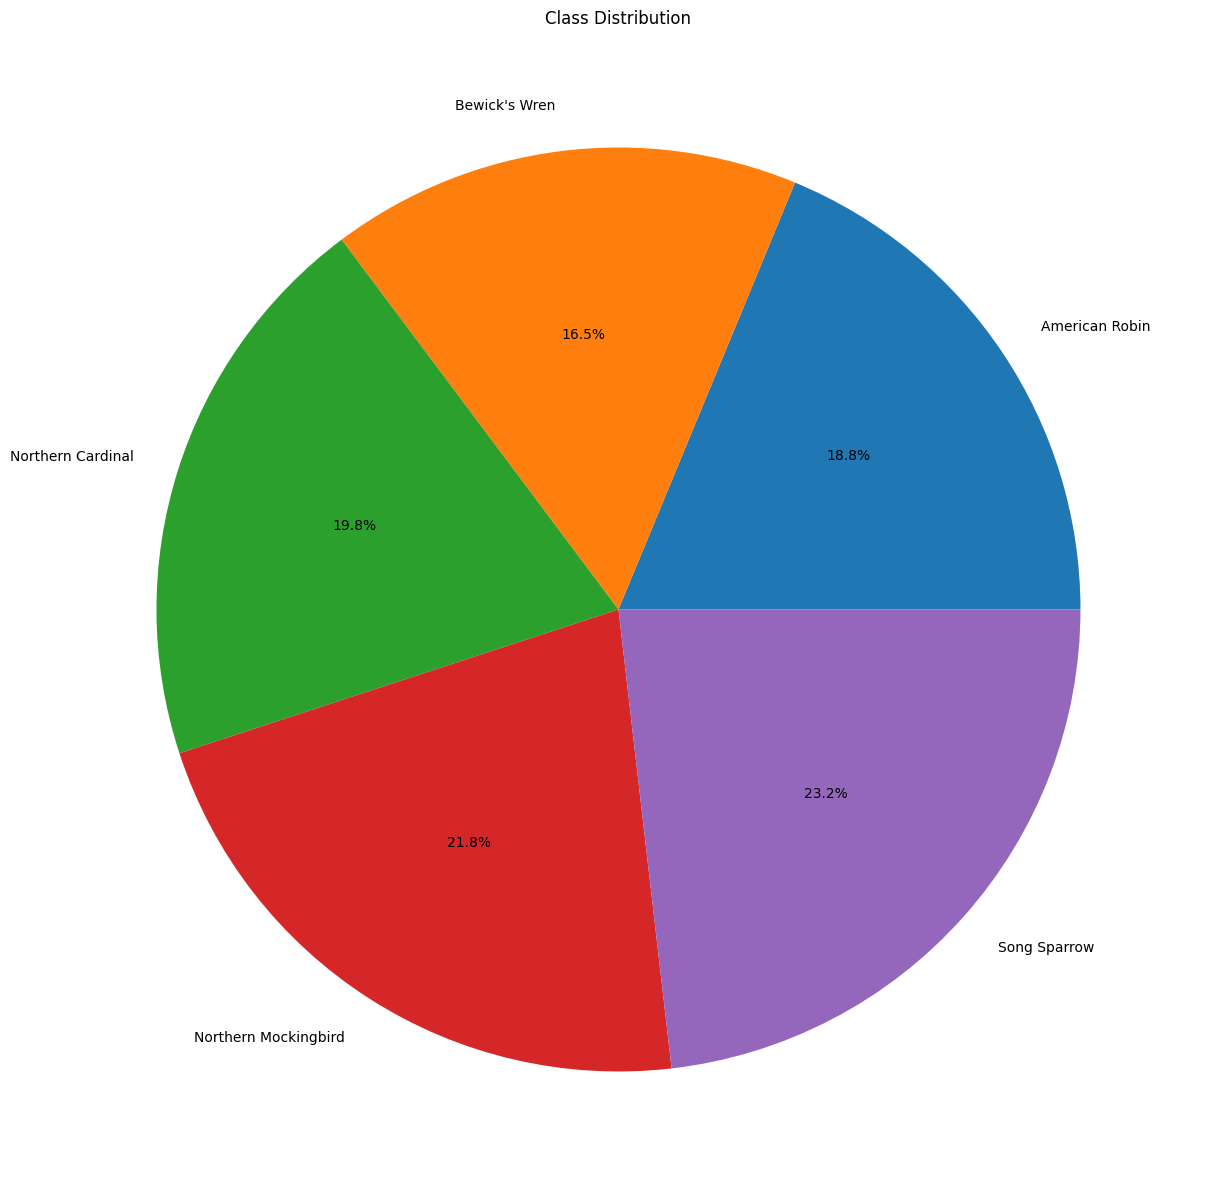

In [68]:
classes = list(np.unique(data.name))
class_dist = data.groupby(['name']).size()
print(class_dist)

fig, ax = plt.subplots()
fig.set_size_inches(15,15)
ax.set_title('Class Distribution')
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%')
plt.show()

In [105]:
def create_spectrogram_pickle(audio_file, pickle_file):
    signal, sample_rate = librosa.load(audio_file)

    ms = librosa.feature.melspectrogram(y=signal, sr=sample_rate)
    log_ms = librosa.power_to_db(ms, ref=np.max)

    with open(pickle_file, 'wb') as f:
        pickle.dump((log_ms, sample_rate), f)

def create_pickles_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for file in tqdm(os.listdir(input_path)):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.pickle'))
        create_spectrogram_pickle(input_file, output_file)

In [70]:
data_dir = 'data/wavfiles/'

In [71]:
# create_pickles_from_wavs(data_dir, 'out/db')

In [106]:
def create_spectrogram_plt(pickle_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    with open(pickle_file, 'rb') as f:
        log_ms, sample_rate = pickle.load(f)

    librosa.display.specshow(log_ms, sr=sample_rate)

    fig.savefig(image_file)
    plt.close(fig)


def create_pngs_from_pickles(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for file in tqdm(os.listdir(input_path)):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.pickle', '.png'))
        create_spectrogram_plt(input_file, output_file)

In [ ]:
# create_pngs_from_pickles('out/db', 'out/png')

In [ ]:
# !zip -r outpng.zip out/png

In [ ]:
# !zip -r outdb.zip out/db

In [73]:
!cp ./drive/MyDrive/ML/audio/history.pickle ./
!cp ./drive/MyDrive/ML/audio/new_modelw.h5 ./
!cp ./drive/MyDrive/ML/audio/new_mw.h5 ./
!cp ./drive/MyDrive/ML/audio/outdb.zip ./
!cp ./drive/MyDrive/ML/audio/outpng.zip ./

In [74]:
!unzip -q outpng.zip

In [75]:
string_to_index = {string: index for index, string in enumerate(data['name'].unique())}

index_to_string = {index: string for string, index in string_to_index.items()}

data['class'] = data['name'].map(string_to_index)

data

,filename,name,length,class
0,557838-0.wav,Bewick's Wren,3.0,0
1,557838-1.wav,Bewick's Wren,3.0,0
2,557838-4.wav,Bewick's Wren,3.0,0
3,557838-5.wav,Bewick's Wren,3.0,0
4,557838-6.wav,Bewick's Wren,3.0,0
...,...,...,...,...
5417,11713-8.wav,Northern Cardinal,3.0,4
5418,11713-10.wav,Northern Cardinal,3.0,4
5419,11713-14.wav,Northern Cardinal,3.0,4
5420,11713-15.wav,Northern Cardinal,3.0,4


In [107]:
def load_images_from_path(path):
    images = []
    labels = []
    files = []

    for index, row in tqdm(data.iterrows()):
        path_to_png = os.path.join(path, row["filename"].replace(".wav", ".png")) 
        # TODO: save in correct format
        images.append(keras.utils.img_to_array(keras.utils.load_img(path_to_png, target_size=(32, 32, 3))))
        labels.append(row["class"])
        files.append(row["filename"])
        
    return images, labels, files

In [80]:
png_dir = 'out/png/'

In [108]:
import os

x, y, files = load_images_from_path(png_dir)

5422it [00:43, 125.44it/s]


In [109]:
x_train, x_test, y_train, y_test, f_train, f_test = train_test_split(x, y, files, stratify=y, test_size=0.3, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [110]:
def build_model():
  model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
  ])

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

model = build_model()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_112 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_110 (MaxPooli  (None, 15, 15, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_113 (Conv2D)         (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_111 (MaxPooli  (None, 6, 6, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_114 (Conv2D)         (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_112 (MaxPooli  (None, 2, 2, 128)      

In [111]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)

hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), batch_size=10, epochs=20, callbacks=[es])

Epoch 1/20
380/380 [==============================] - 10s 22ms/step - loss: 1.2006 - accuracy: 0.4609 - val_loss: 0.9857 - val_accuracy: 0.5968
Epoch 2/20
380/380 [==============================] - 10s 27ms/step - loss: 0.9037 - accuracy: 0.6258 - val_loss: 0.9203 - val_accuracy: 0.5925
Epoch 3/20
380/380 [==============================] - 11s 29ms/step - loss: 0.7513 - accuracy: 0.6946 - val_loss: 0.8199 - val_accuracy: 0.6896
Epoch 4/20
380/380 [==============================] - 8s 20ms/step - loss: 0.6275 - accuracy: 0.7605 - val_loss: 0.7543 - val_accuracy: 0.7037
Epoch 5/20
380/380 [==============================] - 11s 28ms/step - loss: 0.5401 - accuracy: 0.7989 - val_loss: 0.6202 - val_accuracy: 0.7689
Epoch 6/20
380/380 [==============================] - 8s 21ms/step - loss: 0.4556 - accuracy: 0.8335 - val_loss: 0.5503 - val_accuracy: 0.7996
Epoch 7/20
380/380 [==============================] - 10s 27ms/step - loss: 0.3900 - accuracy: 0.8627 - val_loss: 0.5287 - val_accuracy: 0

In [112]:
model.save("new_modelw.h5")

In [116]:
with open('history.pickle', 'wb') as f:
    pickle.dump(hist, f)

In [117]:
with open('history.pickle', 'rb') as f:
    history = pickle.load(f)

In [118]:
reconstructed_model = keras.models.load_model("new_modelw.h5")

[]

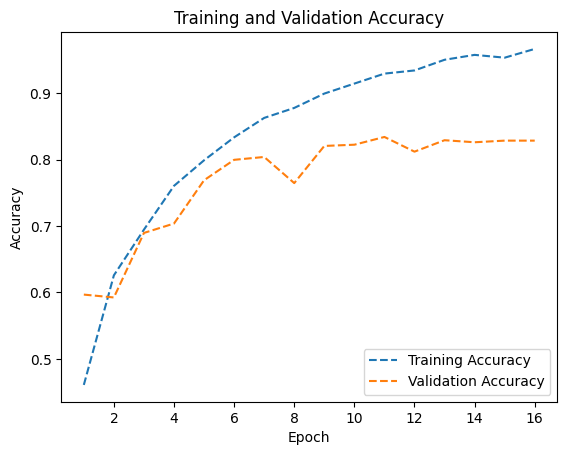

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '--', label='Training Accuracy')
plt.plot(epochs, val_acc, '--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
# y_predicted = model.predict(x_test_norm)

In [120]:
y_predicted = reconstructed_model.predict(x_test_norm)

51/51 [==============================] - 1s 23ms/step


Text(216.25, 0.5, 'Actual label')

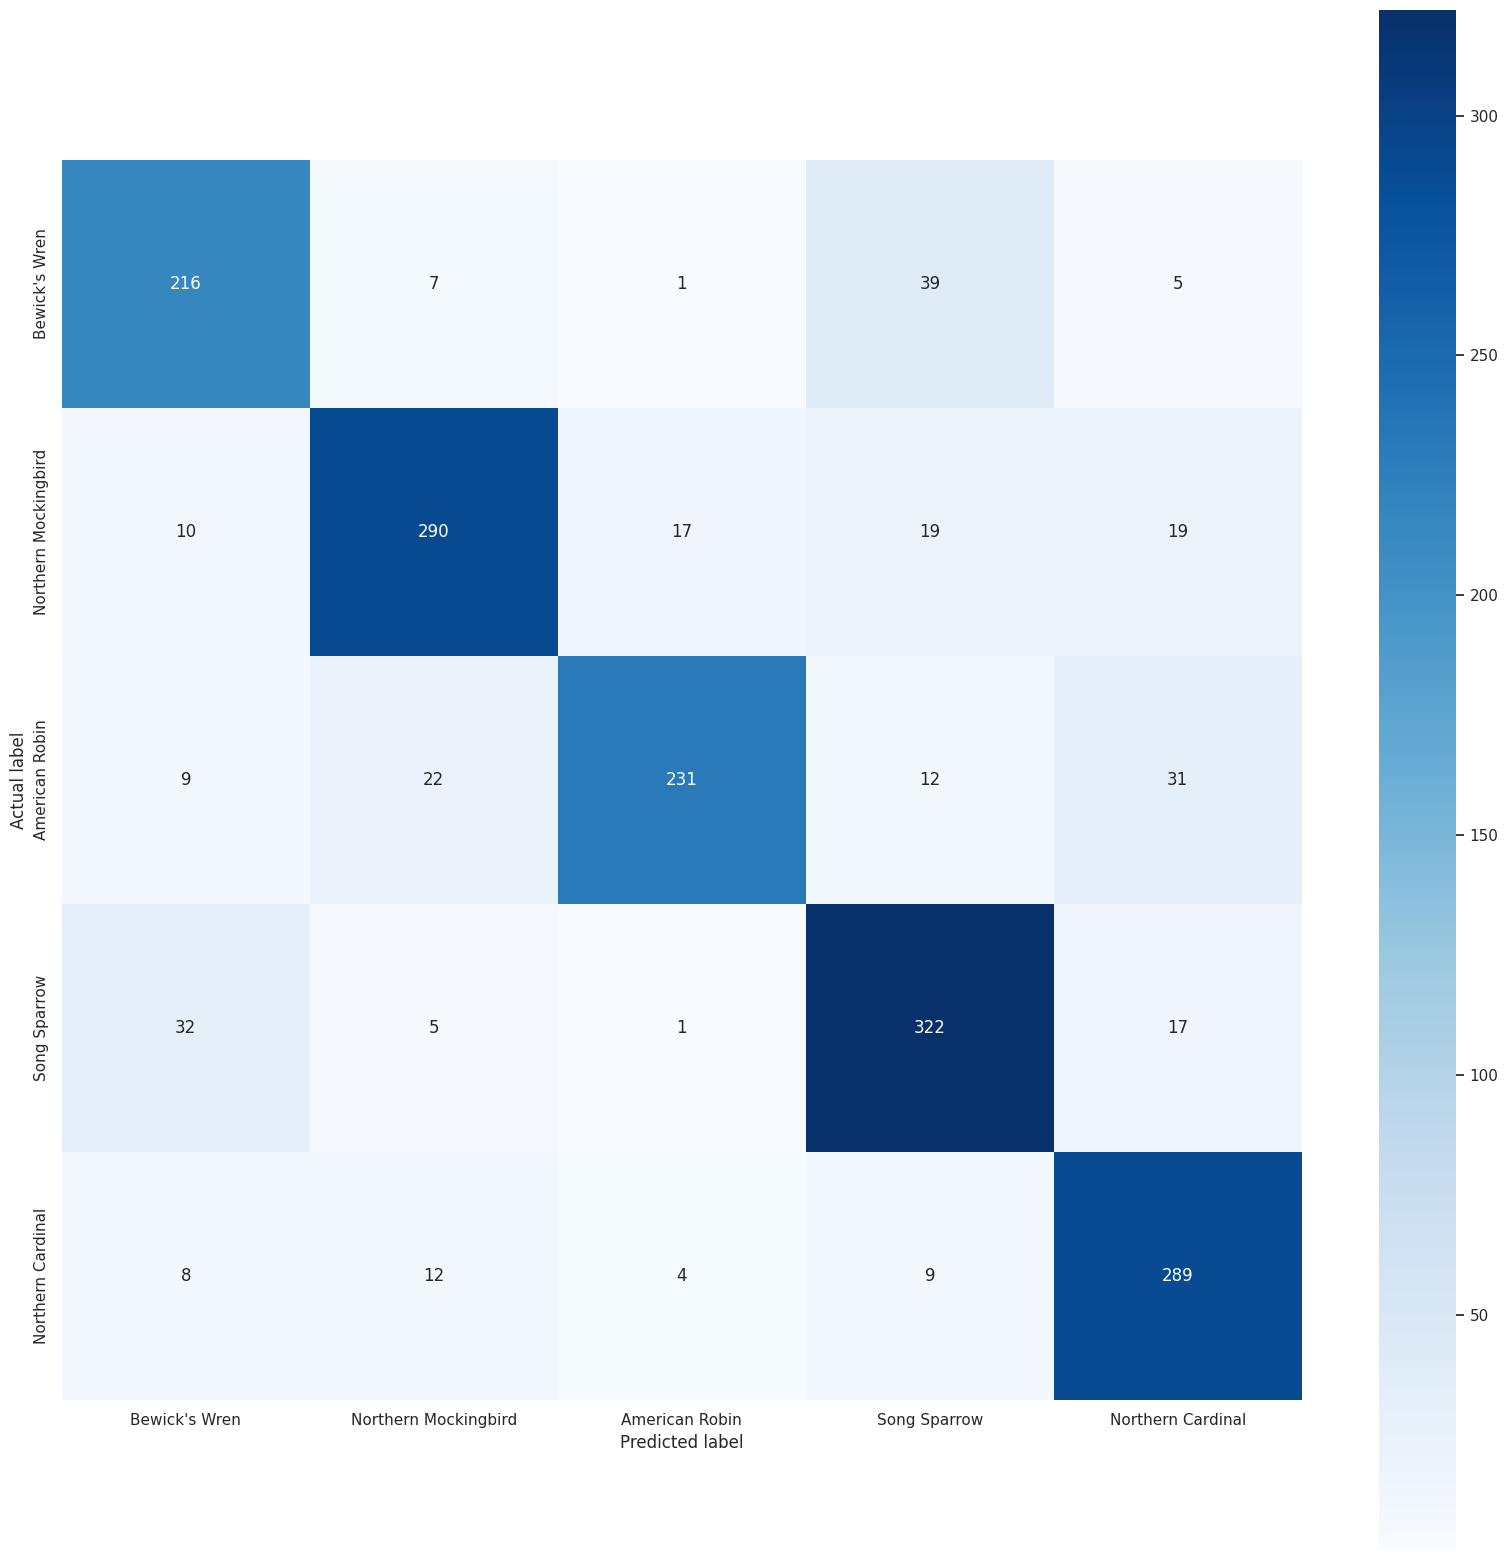

In [121]:
sns.set()

plt.figure(figsize=(20, 20))
mat = confusion_matrix(y_test_encoded.argmax(axis=1), y_predicted.argmax(axis=1))

birds = list(index_to_string.values())
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap='Blues',
            xticklabels=birds,
            yticklabels=birds)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [122]:
reducer = umap.UMAP(n_neighbors=len(birds), min_dist=0.1, n_components=2)
embedding = reducer.fit_transform(y_predicted)

In [123]:
umap.plot.output_notebook()

dot_info = pd.DataFrame({
    'cluster': np.argmax(y_predicted, axis=1),
    'file': f_test,
    'actual': map(lambda x: index_to_string[x], y_test),
    })

dot_info['predicted'] = dot_info.cluster.map(index_to_string)

p = umap.plot.interactive(reducer, labels=np.argmax(y_predicted, axis=1), hover_data=dot_info, point_size=5, color_key_cmap='Paired') 
umap.plot.show(p)

Sound from area:

'data/wavfiles/408811-7.wav'

'data/wavfiles/469351-13.wav'

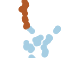

'data/wavfiles/175222-10.wav'

'data/wavfiles/235432-9.wav'

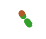

Сlustering screenshot:

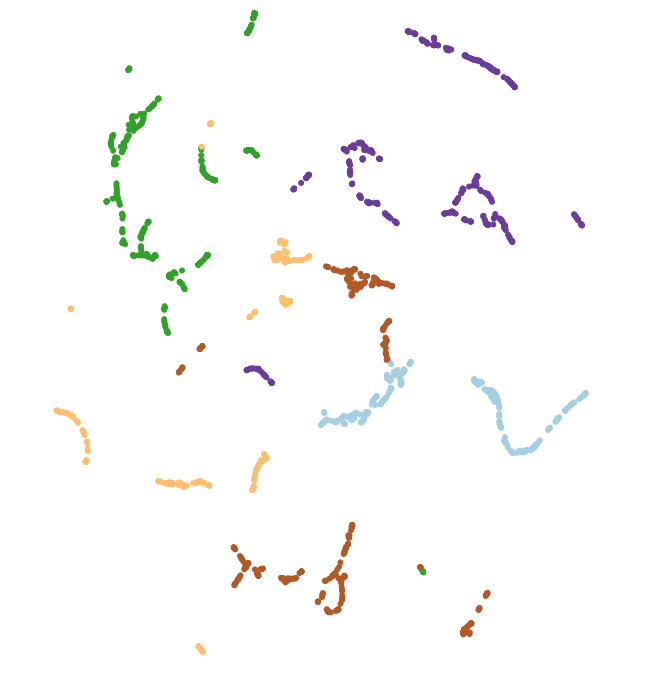

In [124]:
import IPython
IPython.display.display(IPython.display.Audio('data/wavfiles/408811-7.wav'))
IPython.display.display(IPython.display.Audio('data/wavfiles/469351-13.wav'))

In [126]:
import IPython
IPython.display.display(IPython.display.Audio('data/wavfiles/175222-10.wav'))
IPython.display.display(IPython.display.Audio('data/wavfiles/235432-9.wav'))